# Feature Overview
To demonstrate the features of mlwhatif, we will use the running example from the paper.
![overview](paper_example_image.png)

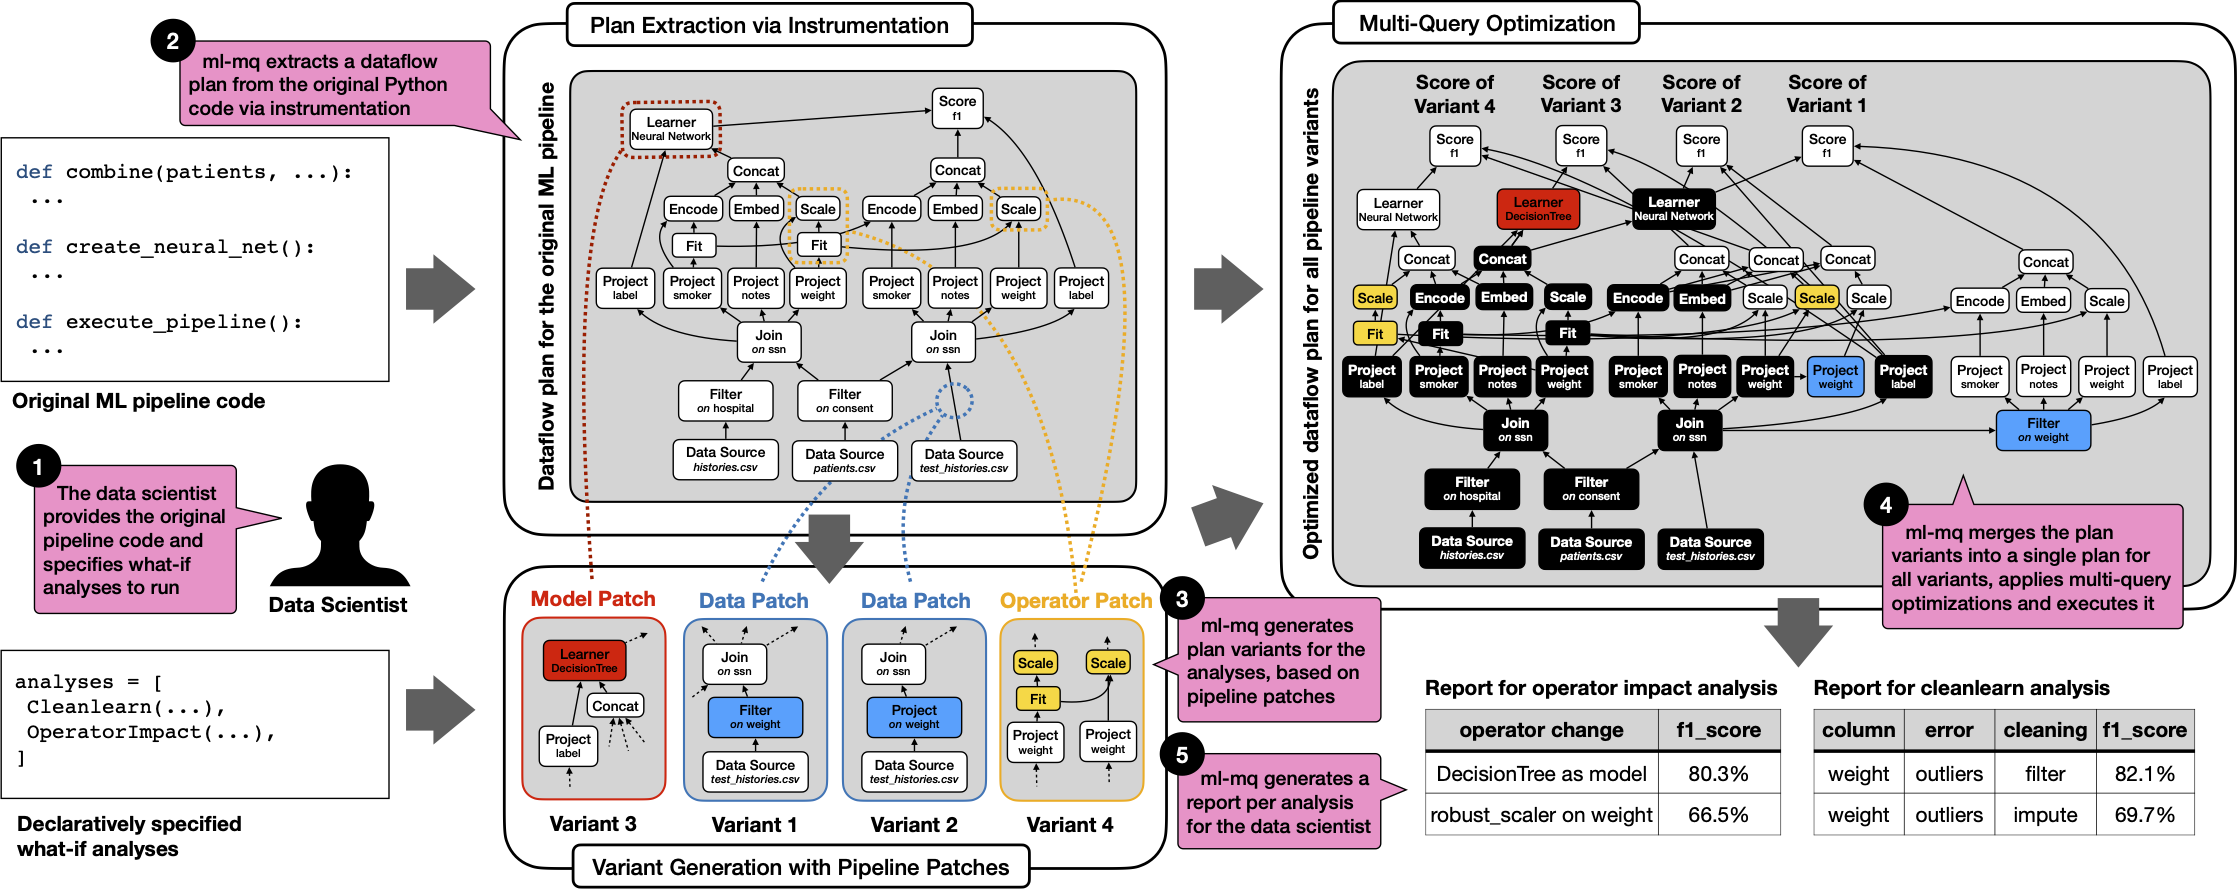

In [1]:
from IPython.core.display import Image
import os
from demo.feature_overview.clean_learn import Clean, ErrorType, CleanLearn
from mlwhatif.utils import get_project_root

EXAMPLE_COMPLEX_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "paper_example_image.png")

Image(filename=f"{EXAMPLE_COMPLEX_PATH}")


Let us start by looking at the full pipeline source code.

In [2]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython
import os
from example_pipelines.healthcare import custom_monkeypatching
from mlwhatif.utils import get_project_root

DEMO_PY = os.path.join(str(get_project_root()), "demo", "feature_overview", "healthcare.py")

with open(DEMO_PY) as pipline_file:
    code = pipline_file.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

To now conduct our what-if analyses, we do not need to rewrite this pipeline file, we can use it directly as input for mlwhatif. Now, let us look at different analyses already implemented in mlwhatif.

## Data Corruption
Here, we test the robustness of our pipeline against different data quality errors.

In [3]:
from mlwhatif import PipelineAnalyzer
import warnings
warnings.filterwarnings('ignore')  # To keep the output readable


cleanlearn = CleanLearn(column="weight",
                        error=ErrorType.OUTLIER,
                        cleanings=[Clean.FILTER, Clean.IMPUTE],
                        outlier_func=lambda y: (y > 120) | (y < 30),
                        impute_constant=70)

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(cleanlearn) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .execute()

cleanlearn_report = analysis_result.analysis_to_result_reports[cleanlearn]

2022-10-14 16:44:23 INFO  Running instrumented original pipeline...
2022-10-14 16:44:23 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2022-10-14 16:44:23 INFO  ---RUNTIME: Importing and monkey-patching took 169.7399616241455 ms
2022-10-14 16:44:24 INFO  ---RUNTIME: Original pipeline execution took 1189.0897750854492 ms (excluding imports and monkey-patching)
2022-10-14 16:44:24 INFO  Starting execution of 1 what-if analyses...
2022-10-14 16:44:24 INFO  Start plan generation for analysis CleanLearn...
2022-10-14 16:44:24 INFO  ---RUNTIME: Plan generation took 0.20623207092285156 ms
2022-10-14 16:44:24 INFO  Estimated runtime of original DAG is 1149.0814685821533ms
2022-10-14 16:44:24 INFO  Performing Multi-Query Optimization
2022-10-14 16:44:24 INFO  Estimated unoptimized what-if runtime is 2298.1629371643066ms
2022-10-14 16:44:24 INFO  Estimated optimised what-if runtime is 1246.1719512939453ms
2022-10-14 16:44:24 INFO  Estima

            weight
0         0.000000
1        77.739653
2     60000.000000
3        58.510919
4         0.000000
...            ...
3905     60.046978
3906  60000.000000
3907     79.650130
3908  60000.000000
3909  60000.000000

[3910 rows x 1 columns]
         weight
0     70.000000
1     77.739653
2     70.000000
3     58.510919
4     70.000000
...         ...
3905  60.046978
3906  70.000000
3907  79.650130
3908  70.000000
3909  70.000000

[3910 rows x 1 columns]


Let us start by looking at the report generated by the analysis. In the first column, wee see the corruption that is being corrupted in the tested pipeline variant. In the second column, wee see the fraction of currupted values in the column. In the third column, wee see the utility score of that variant. In the first row, we see the score of the original pipeline.

Here, find that our pipeline is relatively robust against the tested data quality issues, as long as they appear in one column at a time. The lowest utility score we see is for high fractions of missing values in the `star_rating` column. This would be a candidate for data quality monitoring when deploying the pipeline in production.

In [4]:
cleanlearn_report

,corrupted_column,error,cleaning_method,accuracy_score_L70
0,None,None,None,0.754220
1,weight,outliers,filter,0.800719
2,weight,outliers,impute,0.808440


## Permutation Feature Importance
Next, we try looking at the importance of different features.

In [5]:
from mlwhatif.analysis._permutation_feature_importance import PermutationFeatureImportance

importance = PermutationFeatureImportance()

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(importance) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .execute()

importance_report = analysis_result.analysis_to_result_reports[importance]

2022-10-14 16:44:25 INFO  Running instrumented original pipeline...
2022-10-14 16:44:25 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2022-10-14 16:44:25 INFO  ---RUNTIME: Importing and monkey-patching took 7.172822952270508 ms
2022-10-14 16:44:26 INFO  ---RUNTIME: Original pipeline execution took 898.3132839202881 ms (excluding imports and monkey-patching)
2022-10-14 16:44:26 INFO  Starting execution of 1 what-if analyses...
2022-10-14 16:44:26 INFO  Start plan generation for analysis PermutationFeatureImportance...
2022-10-14 16:44:26 INFO  ---RUNTIME: Plan generation took 0.21195411682128906 ms
2022-10-14 16:44:26 INFO  Estimated runtime of original DAG is 861.990213394165ms
2022-10-14 16:44:26 INFO  Performing Multi-Query Optimization
2022-10-14 16:44:26 INFO  Estimated unoptimized what-if runtime is 2585.970640182495ms
2022-10-14 16:44:26 INFO  Estimated optimised what-if runtime is 1002.7487277984619ms
2022-10-14 16:44:2

Now let us look at the report. We see that the model does not rely on any single feature too much, but that `total_votes` seems to be the most important single feature.

## A small peak under the hood
Internally, mlwhatif extracts a re-executable plan of the original pipeline and uses multi-query optimization to optimize the execution of what-if analyses. Let us take a look at what this looks like for a simple example.
We will try to keep the what-if analysis very simple for readability.

In [6]:
from IPython.core.display import Image
EXAMPLE_ORIGINAL_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "example-orig")
EXAMPLE_OPTIMIZED_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "example-optimised")

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(robustness) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .execute()
analysis_result.save_original_dag_to_path(EXAMPLE_ORIGINAL_PLAN_PATH)
analysis_result.save_optimised_what_if_dags_to_path(EXAMPLE_OPTIMIZED_PLAN_PATH)

NameError: name 'robustness' is not defined

The original DAG.

In [ ]:
Image(filename=f"{EXAMPLE_ORIGINAL_PLAN_PATH}.png")

The optimised DAG. Note how similar it is to the original DAG thanks to multi-query optimisation.

In [ ]:
Image(filename=f"{EXAMPLE_OPTIMIZED_PLAN_PATH}.png")

However, these plans can become very complex quickly.

In [ ]:
EXAMPLE_COMPLEX_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "example-complex")
PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(robustness) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .estimate() \
    .save_optimised_what_if_dags_to_path(EXAMPLE_COMPLEX_PATH)
# Saving the large plan as image and loading it takes some time
Image(filename=f"{EXAMPLE_COMPLEX_PATH}.png")